# 0. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from IPython.display import clear_output
from tqdm import tqdm
from ipywidgets import interact


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
image_size = 128
batch_size = 64
latent_dim = 200
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [3]:
transform = transforms.Compose(([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size), # pick central square crop of it
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])) # normalize images
                                

trainset = torchvision.datasets.CelebA(root='./data', split='train', download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CelebA(root='./data', split='test', download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [4]:
MEAN = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
STD = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)

denormalization = transforms.Normalize((-MEAN / STD).tolist(), (1.0 / STD).tolist())

# 1. Convolutional Autoencoder

## Model class

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # batch_size, 16, 64, 64
            nn.MaxPool2d(2, stride=2), # batch_size, 16, 32, 32
            nn.ELU(), 
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # batch_size, 32, 16, 16
            nn.MaxPool2d(2, stride=2), # batch_size, 8, 8, 8
            nn.ELU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # batch_size, 64, 4, 4
            nn.Flatten(),
            nn.ELU(),
            nn.Linear(64*4*4, latent_dim),
            nn.Tanh()
            )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*4*4),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=3, padding=2),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, x):
        x.permute(0, 3, 1, 2)
        lat = self.encoder(x)
        rec = self.decoder(lat)
        return rec

def train_autoencoder(model, trainloader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    loss_history = []
    for epoch in range(num_epochs):
        for i, batch in enumerate(trainloader):
            img, _ = batch
            clear_output(wait=True)

            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

            if (i + 1) % 100 == 0:
                plt.figure(figsize=(15, 10))
                plt.plot(loss_history)
                plt.xlabel('Step')
                plt.ylabel('Loss')
                plt.title(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
                plt.show()

    return model

## Training the model

In [6]:
model = Autoencoder(latent_dim=latent_dim)
model.to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
               ELU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
               ELU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
           Flatten-8                 [-1, 1024]               0
               ELU-9                 [-1, 1024]               0
           Linear-10                  [-1, 200]         205,000
             Tanh-11                  [-1, 200]               0
           Linear-12                 [-1, 1024]         205,824
        Unflatten-13             [-1, 64, 4, 4]               0
  ConvTranspose2d-14             [-1, 3

In [ ]:
model = train_autoencoder(model, trainloader, num_epochs=1, learning_rate=1e-3)

In [30]:
torch.save(model.state_dict(), 'autoencoder_lat200.pt')

## Testing the model

In [28]:
AE = Autoencoder(latent_dim=latent_dim)
AE.load_state_dict(torch.load('autoencoder_lat200.pt'))
AE.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ELU(alpha=1.0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ELU(alpha=1.0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=1024, out_features=200, bias=True)
    (10): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), pad

## Test 0: Random images

In [34]:
def test_AE(model, testloader, n=5):
    model.eval()
    with torch.no_grad():
        # take n * n random images from a test set
        test_images = next(iter(testloader))[0][:n*n]
        test_images = test_images.to(device)
        # encode and decode them
        encoded = model.encoder(test_images)
        decoded = model.decoder(encoded)
        # denormalize images
        test_images = denormalization(test_images)
        decoded = denormalization(decoded)
        # plot them
        fig, axs = plt.subplots(n, n, figsize=(15, 15))
        for i in range(n):
            for j in range(n):
                axs[i, j].imshow(test_images[i*n + j].permute(1, 2, 0).cpu().numpy())
                axs[i, j].axis('off')
        plt.show()
        fig, axs = plt.subplots(n, n, figsize=(15, 15))
        for i in range(n):
            for j in range(n):
                axs[i, j].imshow(decoded[i*n + j].permute(1, 2, 0).cpu().numpy())
                axs[i, j].axis('off')

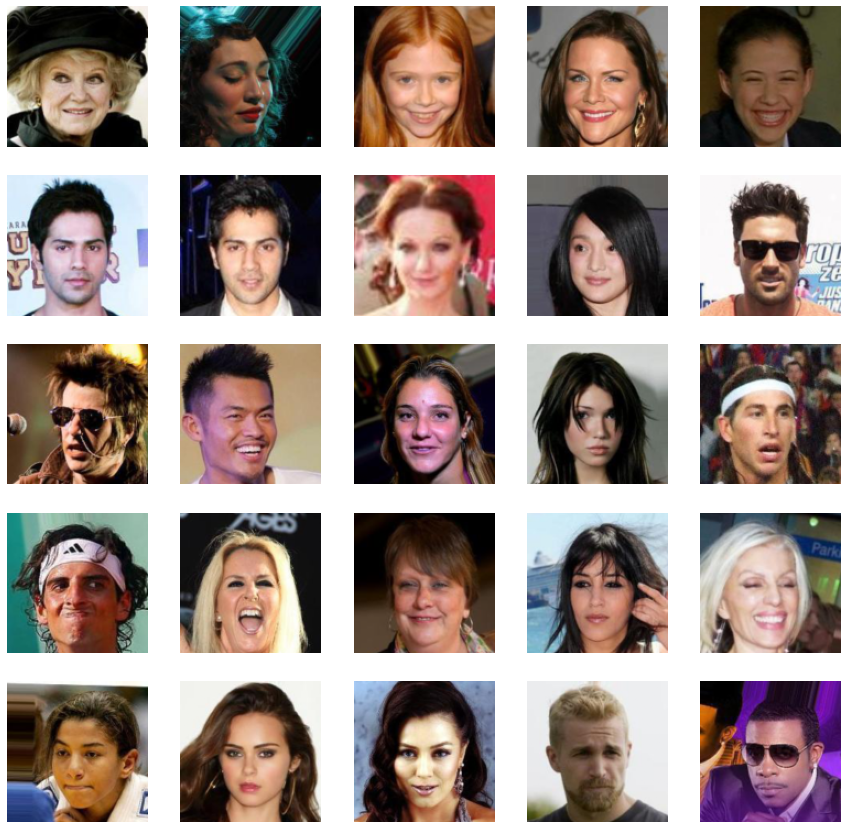

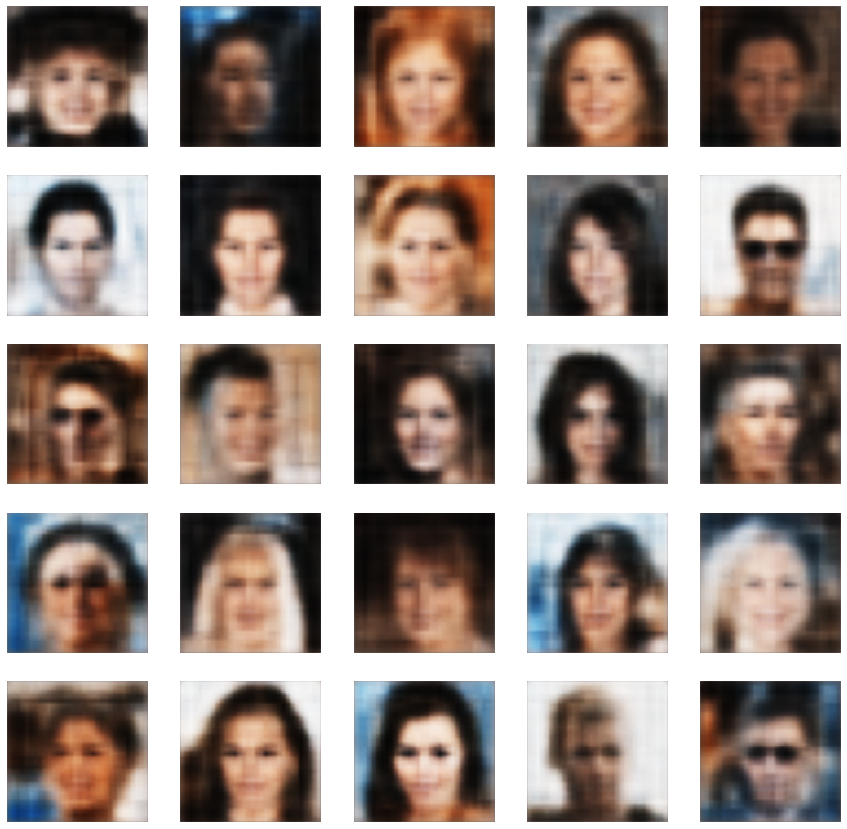

In [30]:
test_AE(model=AE, testloader=testloader, n=5)

## Test 1: Latent arithmetic

In [32]:
SEX_INDEX = 21 - 1
EYEGLASSES_INDEX = 16 - 1

def get_avg_by_labels(testset, label_idx_list):
    mask = torch.zeros((testset.attr.shape[1]), dtype=torch.bool)
    for idx in label_idx_list:
        mask[idx] = True
    mask = (testset.attr[:, mask] == torch.ones(len(label_idx_list), dtype=torch.int64)).prod(dim=1).squeeze()
    idxs = torch.nonzero(mask)
    result = torch.zeros(3, 128, 128)
    for i in tqdm(idxs):
        i.squeeze_()
        result += testset[i][0]
    result /= len(idxs)
    return result

def encode(model, img):
    model.eval()
    with torch.no_grad():
        lat = model.encoder(img.to(device))
    return lat

def decode(model, lat):
    model.eval()
    with torch.no_grad():
        rec = model.decoder(lat)
    return rec

In [12]:
avg_male_with_glasses = get_avg_by_labels(testset, [SEX_INDEX, EYEGLASSES_INDEX])
avg_male = get_avg_by_labels(testset, [SEX_INDEX])

mask = torch.zeros((testset.attr.shape[1]), dtype=torch.bool)
mask[20] = True
mask = (testset.attr[:, mask] == 0).prod(dim=1).squeeze()
idxs = torch.nonzero(mask)
avg_female = torch.zeros(3, 128, 128)
for i in tqdm(idxs):
    i.squeeze_()
    avg_female += testset[i][0]
avg_female /= len(idxs)

100%|██████████| 12247/12247 [00:22<00:00, 536.02it/s]


In [13]:
avg_male_with_glasses_lat = encode(model=AE, img=avg_male_with_glasses.unsqueeze(0).to(device))
avg_male_lat = encode(model=AE, img=avg_male.unsqueeze(0).to(device))
avg_female_lat = encode(model=AE, img=avg_female.unsqueeze(0).to(device))

glass_vector = avg_male_with_glasses_lat - avg_male_lat
avg_female_with_glasses_lat = avg_female_lat + glass_vector
avg_female_with_glasses = decode(model=AE, lat=avg_female_with_glasses_lat).squeeze(0)
avg_female_rec = decode(model=AE, lat=avg_female_lat).squeeze(0)

Text(0.5, 1.0, 'Average female reconstruction')

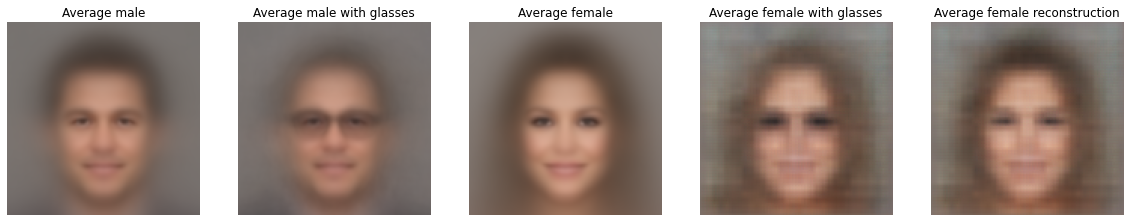

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

axs[0].imshow(denormalization(avg_male).permute(1, 2, 0))
axs[0].axis('off')
axs[0].set_title('Average male')

axs[1].imshow(denormalization(avg_male_with_glasses).permute(1, 2, 0))
axs[1].axis('off')
axs[1].set_title('Average male with glasses')

axs[2].imshow(denormalization(avg_female).permute(1, 2, 0))
axs[2].axis('off')
axs[2].set_title('Average female')

axs[3].imshow(denormalization(avg_female_with_glasses).permute(1, 2, 0).cpu().detach().numpy())
axs[3].axis('off')
axs[3].set_title('Average female with glasses')

axs[4].imshow(denormalization(avg_female_rec).cpu().permute(1, 2, 0))
axs[4].axis('off')
axs[4].set_title('Average female reconstruction')

## Test 2: Interpolation

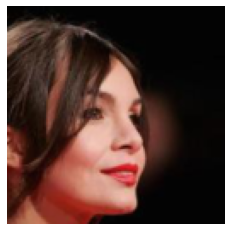

In [35]:
# take a random image from a test set
idx = np.random.randint(len(testset))
img = testset[idx][0]
plt.imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
img = img.unsqueeze(0).to(device)

In [39]:
def plot_neighborhood(model, img, n=5, alpha=0.1):
    lat = encode(model, img)
    lat = lat.squeeze(0)
    lat = lat.unsqueeze(0)
    lat = lat.repeat(n, 1)
    lat = lat.unsqueeze(0)
    lat = lat.repeat(n, 1, 1)
    lat = lat.to(device)
    lat = lat + torch.randn_like(lat) * alpha

    rec = decode(model, lat.view(-1, latent_dim)).view(n, n, 3, 128, 128)
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(n):
        for j in range(n):
            axs[i, j].imshow(denormalization(rec[i, j]).permute(1, 2, 0).cpu().numpy())
            axs[i, j].axis('off')

@interact(alpha=(0.0, 1.0, 0.1))
def plot_neighborhood_interact(alpha=0.1):
    plot_neighborhood(model=AE, img=img, alpha=alpha)

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

## Test 3: Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstruction of noisy image')

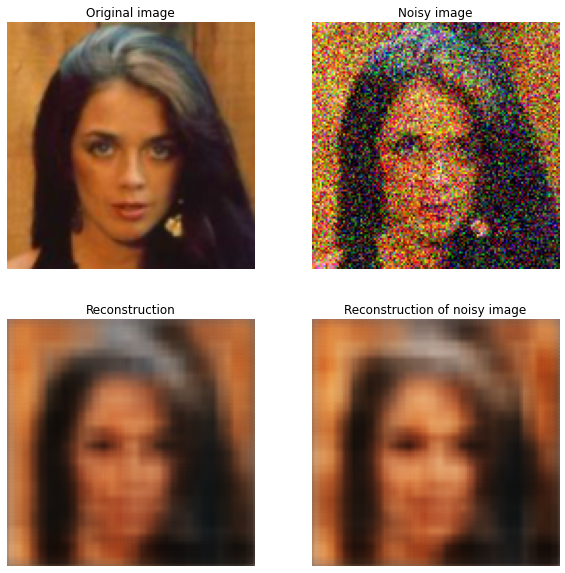

In [52]:
idx = np.random.randint(len(testset))
img = testset[idx][0]
noisy_img = img + torch.randn_like(img) * 0.5

#plot them
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
axs[0][0].axis('off')
axs[0][0].set_title('Original image')

axs[0][1].imshow(denormalization(noisy_img).permute(1, 2, 0).cpu().numpy())
axs[0][1].axis('off')
axs[0][1].set_title('Noisy image')

axs[1][0].imshow(denormalization(decode(AE, encode(AE, img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][0].axis('off')
axs[1][0].set_title('Reconstruction')

axs[1][1].imshow(denormalization(decode(AE, encode(AE, noisy_img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][1].axis('off')
axs[1][1].set_title('Reconstruction of noisy image')

# 2. Variational Autoencoder

## Model class

In [5]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(ConvolutionalVAE, self).__init__()
        self.loss_dict = {
            'reconstruction_loss': [],
            'kl_divergence': []}
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # batch_size, 16, 64, 64
            nn.MaxPool2d(2, stride=2), # batch_size, 16, 32, 32
            nn.BatchNorm2d(16),
            nn.LeakyReLU(), 
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # batch_size, 32, 16, 16
            nn.MaxPool2d(2, stride=2), # batch_size, 8, 8, 8
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # batch_size, 64, 4, 4
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.Flatten()
            )
        h_dim = 64*4*4
        self.fc1 = nn.Linear(h_dim, self.latent_dim)
        self.fc2 = nn.Linear(h_dim, self.latent_dim)
        # self.fc3 = nn.Linear(self.latent_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*4*4),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=3, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh())

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        x.permute(0, 3, 1, 2)

#         print("x:",x.shape)
        h = self.encoder(x)
#         print("h:",h.shape)
        
        z, mu, logvar = self.bottleneck(h)
#         print("z:",z.shape)
        

        return [self.decoder(z), mu, logvar]
    
# ********************************************************************************************************************************
    
    def loss_fn(self, recon_x, x, mu, logvar):
#         print(recon_x)
#         print(x)
        BCE = F.binary_cross_entropy((recon_x+1)/2, (x+1)/2, reduction='sum')
        # MSE = F.mse_loss(recon_x, x, reduction='none').sum(dim=(1,2,3)).mean()

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        
        self.loss_dict['reconstruction_loss'].append(BCE.item())
        self.loss_dict['kl_divergence'].append(KLD.item())
        return BCE + KLD


## Training the model

In [25]:
def train(model, trainloader, optimizer, epochs=10):
    loss_history = []
    # model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(trainloader):
            data = data.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = model.loss_fn(recon_batch, data, mu, logvar)
            loss.backward()
            loss_history.append(loss.item())
            optimizer.step()
            
            if batch_idx % 100 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 10))
                plt.plot(loss_history, label='loss')
                plt.plot(model.loss_dict['reconstruction_loss'], label='reconstruction loss')
                plt.plot(model.loss_dict['kl_divergence'], label='kl divergence')
                plt.legend()
                plt.xlabel('batch')
                plt.ylabel('loss')
                plt.title(f'Epoch: {epoch}, step: {batch_idx}/{len(trainloader)}\nloss: {loss.item():.3f}\nreconstruction loss: {model.loss_dict["reconstruction_loss"][-1]:.3f}\nkl divergence: {model.loss_dict["kl_divergence"][-1]:.3f}')
                plt.show()

In [43]:
model = ConvolutionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.load_state_dict(torch.load('vae_200lat.pt'))
# summary(model, (3, 128, 128))

<All keys matched successfully>

In [ ]:
train(model, trainloader, optimizer, 2)

## Test 0: Random images

In [48]:
def encode(model, img):
    model.eval()
    with torch.no_grad():
        lat = model.encoder(img.to(device))
        z, *_ = model.bottleneck(lat)
    return z

def decode(model, lat):
    model.eval()
    with torch.no_grad():
        rec = model.decoder(lat)
    return rec

VAE = ConvolutionalVAE().to(device)
VAE.load_state_dict(torch.load('vae_200lat.pt'))

<All keys matched successfully>

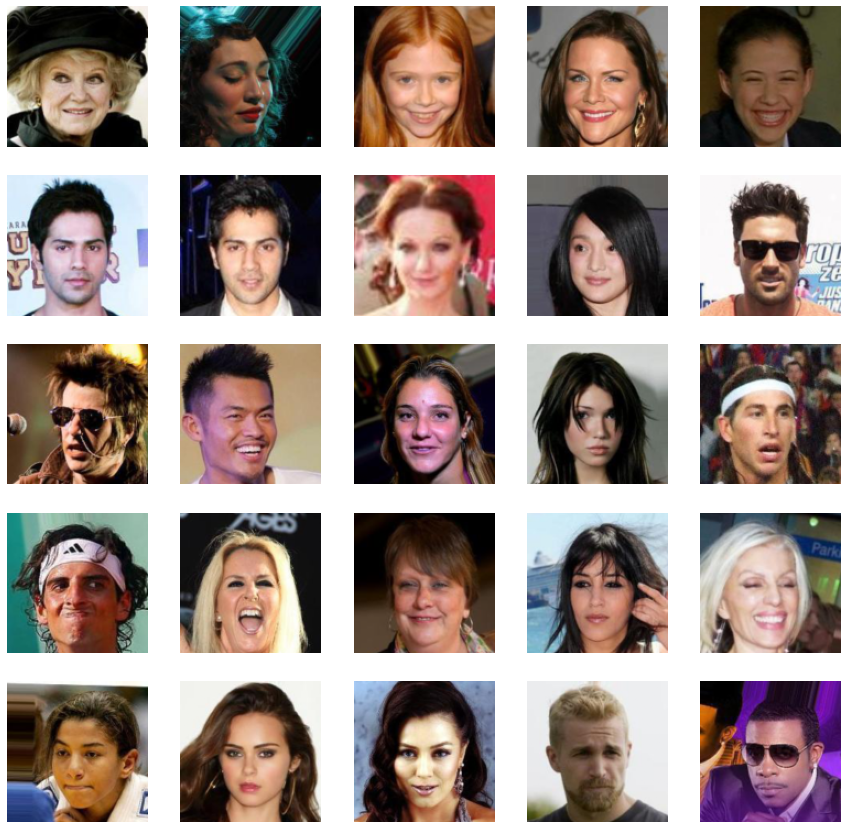

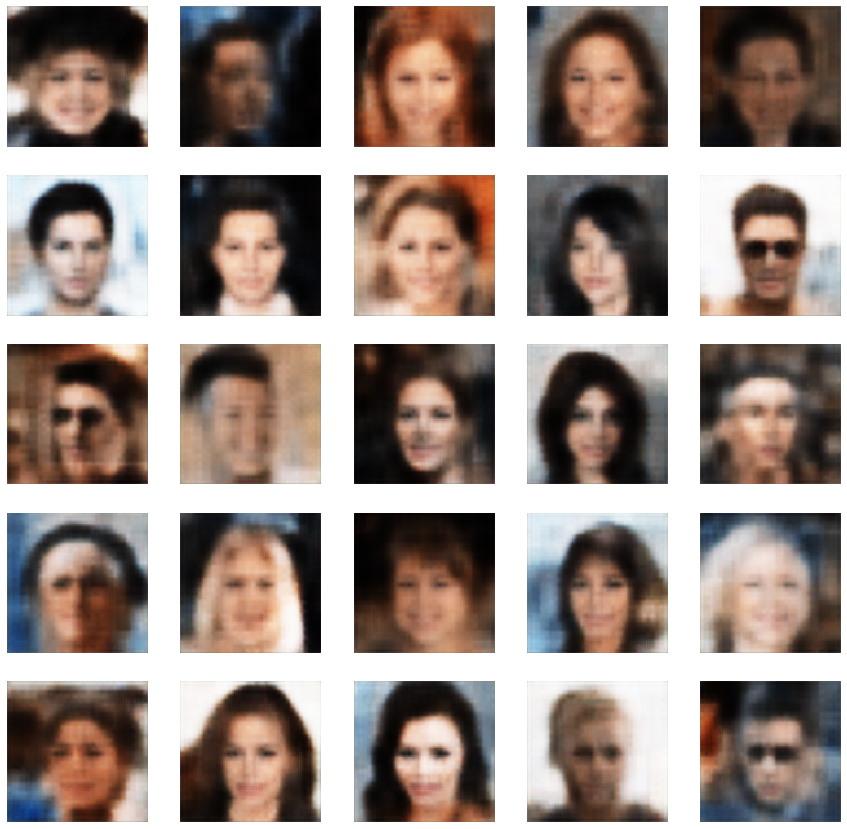

In [7]:
def test_VAE(testloader, model, n=5):
    model.eval()
    with torch.no_grad():
        # take n * n random images from a test set
        test_images = next(iter(testloader))[0][:n*n]
        test_images = test_images.to(device)
        # encode and decode them
        encoded = encode(model, test_images)
        decoded = decode(model, encoded)
        # denormalize images
        test_images = denormalization(test_images)
        decoded = denormalization(decoded)
        # plot them
        fig, axs = plt.subplots(n, n, figsize=(15, 15))
        for i in range(n):
            for j in range(n):
                axs[i, j].imshow(test_images[i*n + j].permute(1, 2, 0).cpu().numpy())
                axs[i, j].axis('off')
        plt.show()
        fig, axs = plt.subplots(n, n, figsize=(15, 15))
        for i in range(n):
            for j in range(n):
                axs[i, j].imshow(decoded[i*n + j].permute(1, 2, 0).cpu().numpy())
                axs[i, j].axis('off')

test_VAE(testloader, VAE, 5)

## Test 1: Latent arithmetic

In [66]:
def get_avg_by_label(testset, label_idx_list):
    mask = torch.zeros((testset.attr.shape[1]), dtype=torch.bool)
    for idx in label_idx_list:
        mask[idx] = True
    mask = (testset.attr[:, mask] == torch.ones(len(label_idx_list), dtype=torch.int64)).prod(dim=1).squeeze()
    idxs = torch.nonzero(mask)
    result = torch.zeros(3, 128, 128)
    for i in tqdm(idxs, desc=f'Computing average for labels {label_idx_list}'):
        i.squeeze_()
        result += testset[i][0]
    result /= len(idxs)
    return result

SEX_INDEX = 21 - 1
EYEGLASSES_INDEX = 16 - 1

In [62]:
avg_male_with_glasses = get_avg_by_label(testset, [SEX_INDEX, EYEGLASSES_INDEX])
avg_male = get_avg_by_label(testset, [SEX_INDEX])

mask = torch.zeros((testset.attr.shape[1]), dtype=torch.bool)
mask[20] = True
mask = (testset.attr[:, mask] == 0).prod(dim=1).squeeze()
idxs = torch.nonzero(mask)
avg_female = torch.zeros(3, 128, 128)
for i in tqdm(idxs, desc='Computing average unglassed female'):
    i.squeeze_()
    avg_female += testset[i][0]
avg_female /= len(idxs)

Computing average unglassed female: 100%|██████████| 12247/12247 [00:19<00:00, 618.17it/s]


In [67]:
avg_male_with_glasses_lat = encode(VAE, avg_male_with_glasses.unsqueeze(0).to(device))
avg_male_lat = encode(VAE, avg_male.unsqueeze(0).to(device))
avg_female_lat = encode(VAE, avg_female.unsqueeze(0).to(device))

glass_vector = avg_male_with_glasses_lat - avg_male_lat
avg_female_with_glasses_lat = avg_female_lat + glass_vector
avg_female_with_glasses = decode(VAE, avg_female_with_glasses_lat).squeeze(0)
avg_female_rec = decode(VAE, avg_female_lat).squeeze(0)

Text(0.5, 1.0, 'Average female reconstruction')

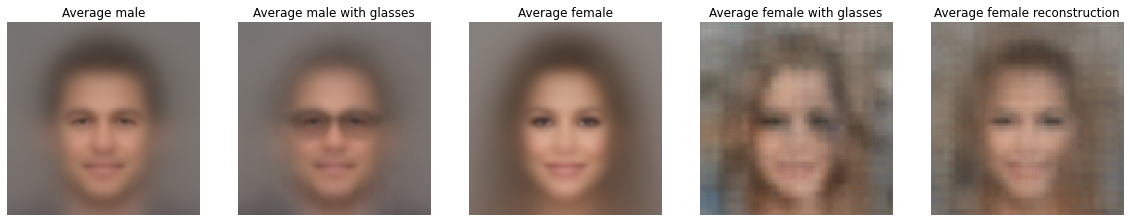

In [69]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

axs[0].imshow(denormalization(avg_male).permute(1, 2, 0))
axs[0].axis('off')
axs[0].set_title('Average male')

axs[1].imshow(denormalization(avg_male_with_glasses).permute(1, 2, 0))
axs[1].axis('off')
axs[1].set_title('Average male with glasses')

axs[2].imshow(denormalization(avg_female).permute(1, 2, 0))
axs[2].axis('off')
axs[2].set_title('Average female')

axs[3].imshow(denormalization(avg_female_with_glasses).permute(1, 2, 0).cpu().detach().numpy())
axs[3].axis('off')
axs[3].set_title('Average female with glasses')

axs[4].imshow(denormalization(avg_female_rec).cpu().permute(1, 2, 0))
axs[4].axis('off')
axs[4].set_title('Average female reconstruction')

## Test 2: Interpolation

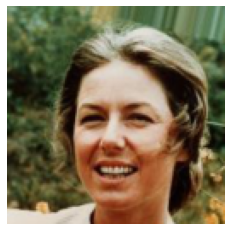

In [49]:
idx = np.random.randint(len(testset))
img = testset[idx][0]
plt.imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
img = img.unsqueeze(0).to(device)

In [65]:
def plot_neighborhood(model, img, n=5, alpha=0.1):
    lat = encode(model, img)

    lat = lat.squeeze(0)
    lat = lat.unsqueeze(0)
    lat = lat.repeat(n, 1)
    lat = lat.unsqueeze(0)
    lat = lat.repeat(n, 1, 1)
    lat = lat.to(device)
    lat = lat + torch.randn_like(lat) * alpha

    rec = decode(model, lat.view(-1, latent_dim)).view(n, n, 3, 128, 128)

    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    plt.suptitle(f'Neighborhood of {n}x{n} images with alpha={alpha}')
    for i in range(n):
        for j in range(n):
            axs[i, j].imshow(denormalization(rec[i, j]).permute(1, 2, 0).cpu().numpy())
            axs[i, j].axis('off')

In [63]:
@interact(alpha=(0.0, 1.0, 0.1))
def plot_neighborhood_interact(alpha=0.1):
    plot_neighborhood(model=VAE, img=img, alpha=alpha)

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

## Test 3: Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstruction of noisy image')

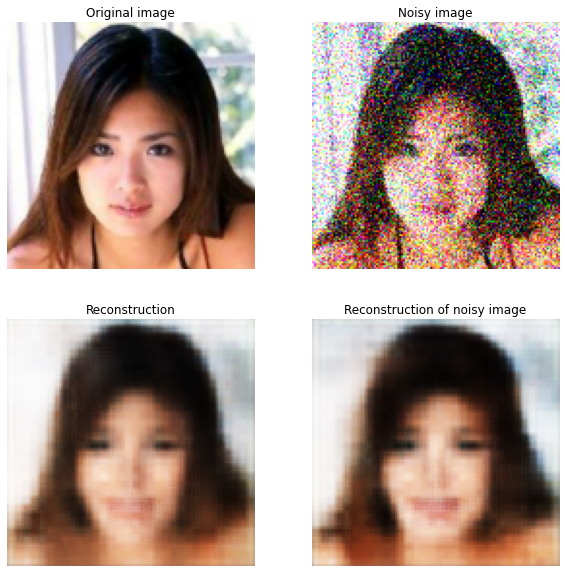

In [71]:
idx = np.random.randint(len(testset))
img = testset[idx][0]
noisy_img = img + torch.randn_like(img) * 0.5

#plot them
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
axs[0][0].axis('off')
axs[0][0].set_title('Original image')

axs[0][1].imshow(denormalization(noisy_img).permute(1, 2, 0).cpu().numpy())
axs[0][1].axis('off')
axs[0][1].set_title('Noisy image')

axs[1][0].imshow(denormalization(decode(VAE, encode(VAE, img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][0].axis('off')
axs[1][0].set_title('Reconstruction')

axs[1][1].imshow(denormalization(decode(VAE, encode(VAE, noisy_img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][1].axis('off')
axs[1][1].set_title('Reconstruction of noisy image')